In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

# Explore Datas and plot them

In [3]:
df_message = pd.read_csv("HF_Data/LOBSTER_SampleFile_MSFT_2012-06-21_50/MSFT_2012-06-21_34200000_37800000_message_50.csv")
df_message.head()

,34200.01399412,3,16085616,100,310400,-1
0,34200.013994,1,16116348,100,310500,-1
1,34200.015248,1,16116658,100,310400,-1
2,34200.015442,1,16116704,100,310500,-1
3,34200.015789,1,16116752,100,310600,-1
4,34200.016300,1,16116815,100,310700,-1


In [4]:
# Renommer les colonnes de df_messages selon la spécification
rename_mapping = {
    df_message.columns[0]: "Time",        # Seconds after midnight (float, ms à ns)
    df_message.columns[1]: "Type",        # Type d'événement (1,2,3,4,5,7)
    df_message.columns[2]: "OrderID",     # Identifiant unique de l'ordre
    df_message.columns[3]: "Size",        # Nombre d'actions
    df_message.columns[4]: "Price",       # Prix * 10 000
    df_message.columns[5]: "Direction"    # -1: Sell, 1: Buy
}

df_message = df_message.rename(columns=rename_mapping)

# Vérification
print(df_message.head())
print("\nColonnes renommées :", df_message.columns.tolist())


           Time  Type   OrderID  Size   Price  Direction
0  34200.013994     1  16116348   100  310500         -1
1  34200.015248     1  16116658   100  310400         -1
2  34200.015442     1  16116704   100  310500         -1
3  34200.015789     1  16116752   100  310600         -1
4  34200.016300     1  16116815   100  310700         -1

Colonnes renommées : ['Time', 'Type', 'OrderID', 'Size', 'Price', 'Direction']


In [5]:
df_OB  = pd.read_csv("HF_Data/LOBSTER_SampleFile_MSFT_2012-06-21_50/MSFT_2012-06-21_34200000_37800000_orderbook_50.csv")
df_OB.head()

,309900,3788,309500,300,310500,100,309300,3986,310600,100.1,...,-9999999999.7,0.20,9999999999.13,0.21,-9999999999.8,0.22,9999999999.14,0.23,-9999999999.9,0.24
0,309900,3788,309500,300,310500,200,309300,3986,310600,100,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
1,309900,3788,309500,300,310400,100,309300,3986,310500,200,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
2,309900,3788,309500,300,310400,100,309300,3986,310500,300,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
3,309900,3788,309500,300,310400,100,309300,3986,310500,300,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0
4,309900,3788,309500,300,310400,100,309300,3986,310500,300,...,-9999999999,0,9999999999,0,-9999999999,0,9999999999,0,-9999999999,0


In [6]:
num_levels = 50

new_columns = []
for level in range(1, num_levels + 1):
    new_columns += [
        f"AskPrice_{level}",  # Prix Ask du niveau i
        f"AskSize_{level}",   # Volume Ask du niveau i
        f"BidPrice_{level}",  # Prix Bid du niveau i
        f"BidSize_{level}",   # Volume Bid du niveau i
    ]

if len(df_OB.columns) != len(new_columns):
    raise ValueError(
        f"Le DataFrame df_OB contient {len(df_OB.columns)} colonnes, "
        f"mais {len(new_columns)} étaient attendues pour {num_levels} niveaux."
    )

df_OB.columns = new_columns

print(df_OB.columns[:8])  # affiche les premières colonnes pour vérif
print(f"\nTotal colonnes renommées : {len(df_OB.columns)}")


Index(['AskPrice_1', 'AskSize_1', 'BidPrice_1', 'BidSize_1', 'AskPrice_2',
       'AskSize_2', 'BidPrice_2', 'BidSize_2'],
      dtype='object')

Total colonnes renommées : 200


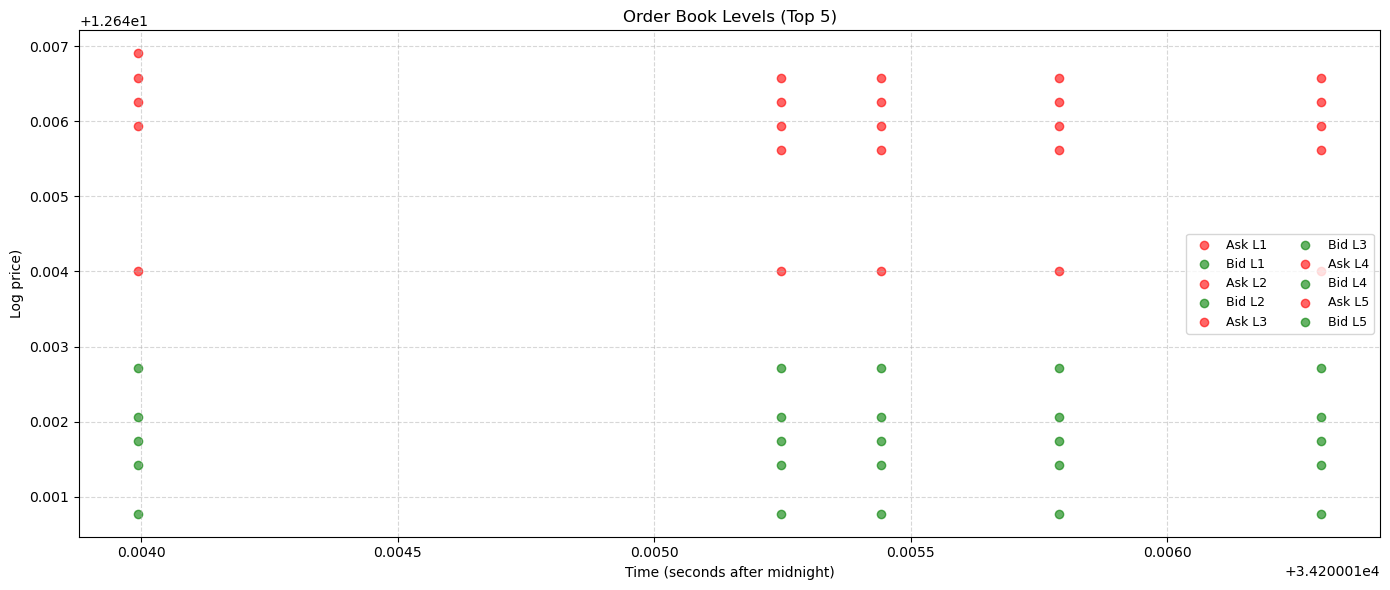

In [7]:
df_OB_with_time = df_OB.copy()
df_OB_with_time["Time"] = df_message["Time"].values

num_levels_to_plot = 5

plt.figure(figsize=(14, 6))

for i in range(1, num_levels_to_plot + 1):
    plt.scatter(df_OB_with_time["Time"][:5], np.log(df_OB_with_time[f"AskPrice_{i}"][:5]), 
             label=f"Ask L{i}", color="red", alpha=0.6)
    plt.scatter(df_OB_with_time["Time"][:5], np.log(df_OB_with_time[f"BidPrice_{i}"][:5]), 
             label=f"Bid L{i}", color="green", alpha=0.6)

plt.xlabel("Time (seconds after midnight)")
plt.ylabel("Log price)")
plt.title(f"Order Book Levels (Top {num_levels_to_plot})")
plt.legend(ncol=2, fontsize=9)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Simulation of Stochastic Volatility process

## Euler Maryama type

In [8]:
# ===========================
# PARAMÈTRES GLOBAUX
# ===========================
T = 1.0        # horizon temporel
N = 1000       # nombre de pas
dt = T / N
t = np.linspace(0, T, N+1)

beta_0 = -0.5  # constante du log-vol
mu = 1.2       # drift de X_t

In [9]:
# ===========================
# SIMULATION
# ===========================
def simulate_process(rho=0.5, alpha=-2.0, beta_1=0.8, seed=42):
    np.random.seed(seed)
    X = np.zeros(N+1)
    tau = np.zeros(N+1)
    
    for i in range(N):
        # Génération des normales corrélées
        Z1, Z2 = np.random.normal(0, 1, 2)
        Z2_corr = rho * Z1 + np.sqrt(1 - rho**2) * Z2

        dB = np.sqrt(dt) * Z1
        dW = np.sqrt(dt) * Z2_corr
        
        sigma_t = np.exp(beta_0 + beta_1 * tau[i])
        
        # Mise à jour Euler–Maruyama
        X[i+1] = X[i] + mu * dt + sigma_t * dB
        tau[i+1] = tau[i] + alpha * tau[i] * dt + dW
    
    sigma = np.exp(beta_0 + beta_1 * tau)
    return t, X, tau, sigma

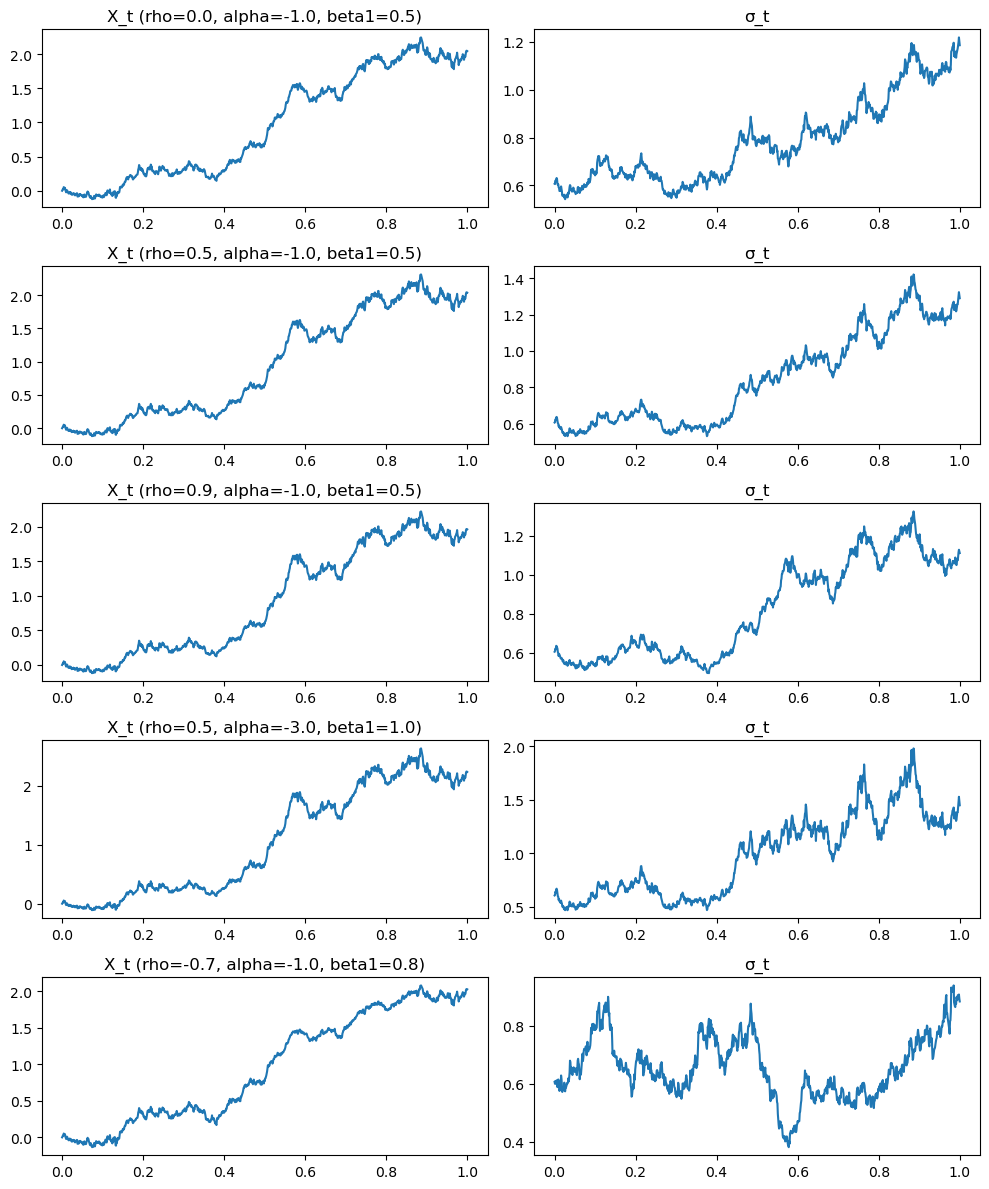

In [10]:
# ===========================
# VISUALISATION
# ===========================
params = [
    {"rho": 0.0, "alpha": -1.0, "beta_1": 0.5},
    {"rho": 0.5, "alpha": -1.0, "beta_1": 0.5},
    {"rho": 0.9, "alpha": -1.0, "beta_1": 0.5},
    {"rho": 0.5, "alpha": -3.0, "beta_1": 1.0},
    {"rho": -0.7, "alpha": -1.0, "beta_1": 0.8},
]

fig, axes = plt.subplots(len(params), 2, figsize=(10, 12))
for i, p in enumerate(params):
    t, X, tau, sigma = simulate_process(**p)
    axes[i, 0].plot(t, X)
    axes[i, 0].set_title(f"X_t (rho={p['rho']}, alpha={p['alpha']}, beta1={p['beta_1']})")
    axes[i, 1].plot(t, sigma)
    axes[i, 1].set_title("σ_t")
plt.tight_layout()
plt.show()

## GARCH-SV Model

In [12]:
# ==================================================
# PARAMETERS
# ==================================================
T = 1.0
N = 2000
dt = T / N
t = np.linspace(0, T, N + 1)

# Base parameters
omega0 = 0.05
alpha0_values = [0.05, 0.2, 0.5]
beta0_values = [0.5, 2.0, 5.0]

In [13]:
def simulate_garch_sv(omega0, alpha0, beta0, seed=42):
    np.random.seed(seed)
    
    X = np.zeros(N + 1)
    sigma2 = np.zeros(N + 1)
    sigma2[0] = omega0 / beta0  # start at long-term mean variance
    
    for i in range(N):
        Z1, Z2 = np.random.normal(0, 1, 2)
        
        # Ensure positivity of variance
        sigma = np.sqrt(max(sigma2[i], 1e-8))
        
        # SDE updates (Euler-Maruyama)
        X[i + 1] = X[i] + sigma * np.sqrt(dt) * Z1
        sigma2[i + 1] = sigma2[i] + (omega0 - beta0 * sigma2[i]) * dt + np.sqrt(2 * alpha0) * sigma * np.sqrt(dt) * Z2
        
        # Keep non-negative variance
        sigma2[i + 1] = max(sigma2[i + 1], 0)
    
    return t, X, sigma2


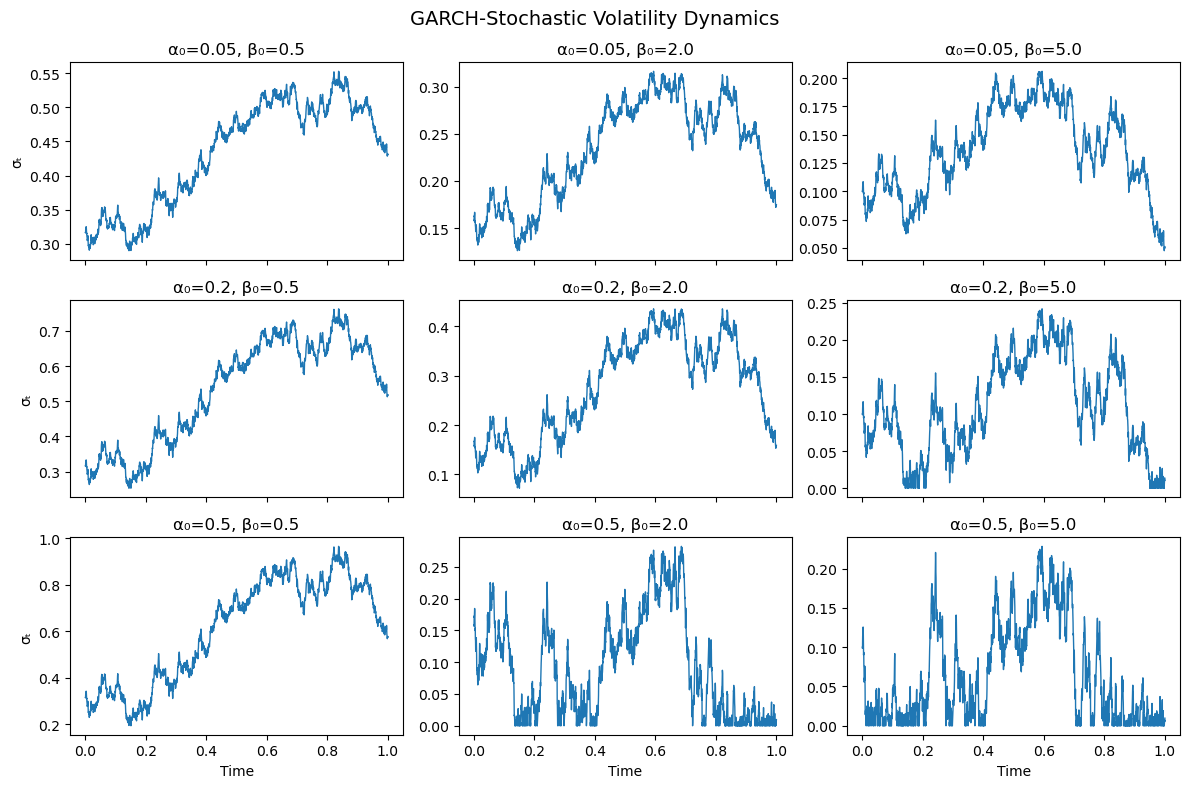

In [14]:
# ==================================================
# PLOTS
# ==================================================
fig, axes = plt.subplots(len(alpha0_values), len(beta0_values), figsize=(12, 8), sharex=True, sharey=False)
for i, alpha0 in enumerate(alpha0_values):
    for j, beta0 in enumerate(beta0_values):
        t, X, sigma2 = simulate_garch_sv(omega0, alpha0, beta0)
        axes[i, j].plot(t, np.sqrt(sigma2), color="tab:blue", lw=1)
        axes[i, j].set_title(f"α₀={alpha0}, β₀={beta0}")
        if i == len(alpha0_values) - 1:
            axes[i, j].set_xlabel("Time")
        if j == 0:
            axes[i, j].set_ylabel("σₜ")
plt.suptitle("GARCH-Stochastic Volatility Dynamics", fontsize=14)
plt.tight_layout()
plt.show()